In [44]:
import pickle
import functools as f
from pymatgen import MPRester
from copy import deepcopy

import pandas as pd
import numpy as np

import pymatgen as mg
import os
import itertools 

API_KEY = "oq6bIVf0EQMI6dun"
mp = MPRester(API_KEY)
save_path = '/Users/dragonlook/Dropbox (MIT)/MI/codes/Copper_Oxide/'

mag_list = pd.read_csv('/Users/dragonlook/Dropbox (MIT)/MI/codes/list/copper_oxide_label.csv')
samples = list(mag_list.Formula.dropna())
mag_elements = list(mag_list.mag_element.dropna())
targets = list(mag_list.target.dropna())
basic_properties = ["energy", "energy_per_atom", "volume",
                                "formation_energy_per_atom", "nsites",
                                "unit_cell_formula", "pretty_formula",
                                "is_hubbard", "elements", "nelements",
                                "e_above_hull", "hubbards", "is_compatible",
                                "spacegroup", "task_ids", "band_gap", "density",
                                "total_magnetization",
                                "material_id", "oxide_type", "tags", "elasticity"]

crystal_fts = ['angle', 'length','nn_sites']

fts = ['energy_per_atom',
       'formation_energy_per_atom', 
       'nsites', 
       'is_hubbard', 'elements', 'nelements', 'e_above_hull',
       'spacegroup', 'band_gap',
       'density', 'total_magnetization', 'oxide_type', 
       'elasticity', 'angle', 'length', 'nn_sites']


In [45]:
# data load
df_dict = {}
df_targets = []
cout = -1
for sample in samples:
    cout += 1
    print(sample)
    sample = sample.strip()
    df_comps = pd.read_csv(save_path + sample + '.csv')
    if len(df_comps) == 0:
        print(sample + ' : no data ')
        continue
    if len(df_comps) == 1:
        df_comp = df_comps
        df_ind = 0
    elif len(df_comps) > 1:
        # take one with lowewest energy per atom
        df_ind = list(df_comps.loc[:,'energy_per_atom']).index(min(list(df_comps.loc[:,'energy_per_atom'])))
        df_comp = df_comps.iloc[df_ind]
    # crystal infomation
    crystal_fts_append = []
    for crystal_ft in crystal_fts:
        ft_file_name = crystal_ft
        if crystal_ft == 'nn_sites':
            ft_file_name = 'length'
        file_crystal = save_path + sample + '/' + sample + '_' + ft_file_name + '_' + str(df_ind) + '.csv'
        df_crystal = pd.read_csv(file_crystal)
        if crystal_ft == 'angle':
            df_crystal = np.sort(list(set(df_crystal.loc[:,'angle'])))
            if df_crystal[0] == 0:
                df_append = df_crystal[1]
            else:
                df_append = df_crystal[0]

        elif crystal_ft == 'length' or 'nn_sites':
            mean_length = []
            mean_neighboring = []
            for i in range(len(df_crystal)):
                res = df_crystal.loc[0,'length'].strip('][').split(' ') 
                res = [float(i) for i in res if len(i)]
                mean_length.append(np.mean(res))
                mean_neighboring.append(len(res))

            if crystal_ft == 'length':
                df_append = np.mean(mean_length)
            elif crystal_ft == 'nn_sites':
                df_append = np.mean(mean_neighboring)

        crystal_fts_append.append(df_append)

    df_append = pd.DataFrame([crystal_fts_append], columns = crystal_fts)
    if len(df_comp.index) == 1:
        df_all = pd.concat([df_comp.T.copy(), df_append.T], axis=0)
    else:
        df_all = pd.concat([df_comp.copy(), df_append.T], axis=0)
    df_all = df_all.T[fts]
    df_dict[sample] = df_all
    df_targets.append(targets[cout])

    
df1 = pd.concat(df_dict, axis=0)
df1 = df1.rename_axis(['name','none'], axis=0)
comp_lists = list(dict.fromkeys(list(df1.index.get_level_values('name'))))
df1.to_csv(save_path + 'pre_predataprocessing.csv')

K2CuF4
KCuF3
CuSb2O6
LiCu2O2
Cs2CuCl4 
SrCu2(BO3)2 
Cu3BiO2(SeO3)2Cl 
Cu2OSeO3 
Cu3Mo2O9 
Cu3(CO3)2(OH)2 
CuGeO3
TlCuCl3
Cu3B2O6 
BiCu2PO6 
Cu2Te2O5Br2 
CuCl2(CH3NH3Cl)2 
CuCl2(CH3NH3Cl)2 : no data 
Cu(NH4)2Br42H2O 
Cu(NH4)2Br42H2O : no data 
(CH3NH3)2CuCl4 
(CH3NH3)2CuCl4 : no data 
(C2H5NH3)2CuCl4 
(C2H5NH3)2CuCl4 : no data 
Cs4CuSb2Cl12 
Cs4CuSb2Cl12 : no data 
CuB2O4 
CsCuCl 
CsCuCl : no data 
Ba2Cu3O4Cl2 
Sr14Cu24O41 
Sr14Cu24O41 : no data 
SrCuO2 
Sr2CuO3 
Ca2Y2Cu5O10 
Ca2Y2Cu5O10 : no data 
La2SrCuO4 
La2SrCuO4 : no data 
Gd2CuO4 
Pr2CuO4
Nd2CuO4
Sm2CuO4
Eu2CuO4
Sr2CuO2Cl2 
BaCu2Si2O7
LiCuVO4
La2Cu2O5
La8Cu7O19
La2CuO4
Cu3Ba2O6


In [46]:
#### preprocessing ####
#target
def target_maker(x):
    if x == 'm' or x == 'me':
        return 1
    else:
        return 0
df_targets = [target_maker(i) for i in df_targets]

lgbm_fts = ['energy_per_atom',
       'formation_energy_per_atom', 
       'nsites', 
       'is_hubbard',  'nelements', 'e_above_hull',
       'band_gap',
       'density', 'total_magnetization', 'oxide_type', 
        'angle', 'length', 'nn_sites']
bin_labs = ['is_hubbard']

df2 = df1[lgbm_fts] 

# False and True lab
for bin_lab in bin_labs:
    df2.loc[:,bin_lab] = df2.copy().apply(lambda x: 1 if x[bin_lab] else 0, axis=1)
# oxide_type
df2.loc[:,'oxide_type'] = df2.copy().apply(lambda x: 1 if x['oxide_type']=='oxide' else 0, axis=1)

/Users/dragonlook/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/dragonlook/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [47]:
from sklearn.model_selection import train_test_split
global X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(df2, df_targets, test_size=0.2, shuffle = True, random_state=100,
                                                    stratify=df_targets)
X_train = X_train.astype(float)
X_test = X_test.astype(float)


In [59]:
print('magnon  ' + str(len(np.where(np.array(df_targets) == 1)[0])))
print('tot  ' + str(len(df_targets)))

magnon  21
tot  31


In [48]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import pandas as pd

import lightgbm as lgbm

from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

def feval_acc_lgbm(pred_proba, dtrain):
    # 真のデータ
    y_true = dtrain.get_label().astype(int)
    # 予測
    y_pred = np.where(pred_proba > 0.5, 1, 0)
    # Accuracy を計算する
    acc = accuracy_score(y_true, y_pred)
    # メトリックの名前と数値を返す(最小化を目指すので 1 から引く)
    return 'accuracy', 1 - acc, False

def lgb_eval(num_leaves,min_data_in_leaf):

    train_df_x = pd.DataFrame(X_train)
    train_df_y = pd.DataFrame(y_train)
    test_df_x = pd.DataFrame(X_test)
    test_df_y = pd.DataFrame(y_test)

    train_data = lgbm.Dataset(X_train, label=y_train)
    eval_data = lgbm.Dataset(X_test, label=y_test, reference= train_data)


    params = {
            'boosting_type':'gbdt',
            'eval_metric':'logloss',
            'objective':'binary',
            'learning_rate':0.01,              
            'num_leaves':int(num_leaves),
            'min_data_in_leaf':int(min_data_in_leaf),
            'max_depth':5,
            'bagging_fraction': 1.0,
            'bagging_freq': 0,
            }


    cls = lgbm.train(params,
            train_data,
            valid_sets=eval_data,
            num_boost_round=1000,
            early_stopping_rounds=20,
            verbose_eval=100,
            )

    pred = cls.predict(X_test)
    score = 1 - log_loss(y_test, pred)
    return score



In [49]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
# from evaluator.super_accuracy import super_accuracy
# from model.tree_visual.mapping_score import mapping_score

# from model.tree.hp.lgb_eval import lgb_eval

import pandas as pd
import lightgbm as lgbm
from matplotlib import pyplot as plt



def lightgbm_bo(train_df_x,train_df_y,test_df_x,test_df_y,num_l=40,min_d=10):

        lgb_evaluate = lgb_eval

        lgb_bo = BayesianOptimization(lgb_evaluate, 
                              {'num_leaves':(20,num_l),
                              'min_data_in_leaf':(3,min_d),                     
                              },
                              verbose=0
                              )

        lgb_bo.maximize(init_points=20, n_iter=50, acq='ei')

        print('Optimized params are:')
        print(lgb_bo.max['params'])

        params = lgb_bo.max['params']
        params['num_leaves'] = int(params['num_leaves'])
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])

        d1 = {
                'boosting_type':'gbdt',
                'eval_metric':'logloss',
                'objective':'binary',
                'learning_rate':0.01,
                'max_depth':31,
                'bagging_fraction': 1.0,
                'bagging_freq': 0,
        }

        params.update(d1)

        return params


In [50]:
params = lightgbm_bo(X_train, X_test, y_train, y_test,num_l=40,min_d=10)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.605408
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.605408
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.605408
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.587942
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.587942
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.604971
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.605408
Training until validation scores don't improve for 20

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.583624
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.583624
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.583624
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.583624
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.583624
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.583624
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.583624
Training until validation scores don't improve f

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	train's binary_logloss: 0.632961	train's accuracy: 0.333333	eval's binary_logloss: 0.599961	eval's accuracy: 0.285714


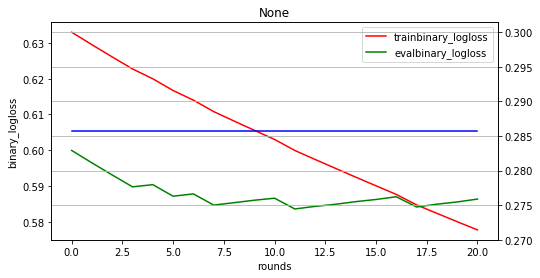

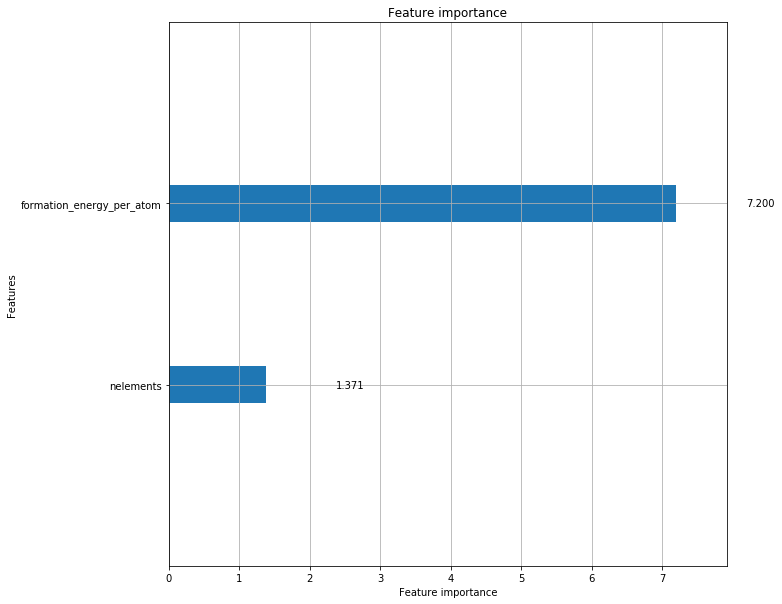

In [60]:
from matplotlib import pyplot as plt
import xgboost as xgb
import pandas as pd

def mapping_score(evals_result,acc,name=None,metric='logloss'):


    fig1, ax1 = plt.subplots(figsize=(8,4))
    train_metric = evals_result['train'][metric] # for xgb: logloss for lgb binary_logloss
    ax1.plot(train_metric, label='train' + metric, c='r')
    eval_metric = evals_result['eval'][metric] # for xgb: logloss
    ax1.plot(eval_metric, label='eval' + metric, c='g')
    ax1.set_ylabel(metric)
    ax1.legend()
    ax1.set_xlabel('rounds')

    # カスタムメトリック
    ax2 = ax1.twinx()
    eval_custom_metric = evals_result['eval']['accuracy']
    ax2.plot(eval_custom_metric, label='eval accuracy', c='b')
#     ax2.set_ylabel('accuracy')
#     ax2.legend()

    plt.grid()
    if type(acc) == int:
        tit = str(acc)
    elif type(acc) == list:
        tit = str()
        cout = 0
        for i in acc:
            tit += str(cout) + 'acc = ' + str(i) + ', '
    else:
        tit = 'None'
    plt.title(tit)
    if name is None:
        plt.savefig('/Users/dragonlook/Desktop/Learning.png')
    elif type(name) is str:
        filename = '/Users/dragonlook/Desktop/' + name + 'Learning.png'
        plt.savefig(filename)
    plt.show()

train_data = lgbm.Dataset(X_train, label=y_train)
eval_data = lgbm.Dataset(X_test, label=y_test, reference= train_data)
evaluation_results = {}
        

cls = lgbm.train(params,
                train_data,
                valid_sets=[train_data, eval_data],
                valid_names=['train', 'eval'],
                evals_result=evaluation_results,
                num_boost_round=1000,
                early_stopping_rounds=20,
                verbose_eval=100,
                feval = feval_acc_lgbm,
                )

pred = cls.predict(X_test)


y_pred = np.where(pred > 0.5, 1, 0)
acc = accuracy_score(y_test, y_pred)
mapping_score(evaluation_results,acc,name='lightbgm',metric='binary_logloss')

_, ax = plt.subplots(figsize=(10, 10))
lgbm.plot_importance(cls,
                        ax=ax,
                        importance_type='gain',
                        )

plt.savefig('/Users/dragonlook/Desktop/test_oxide.png')


In [43]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import numpy as np    
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.linear_model import Ridge
import pandas as pd


def linear_ridge_eval(alpha,max_iter):


    train_df_x = pd.DataFrame(X_train)
    train_df_y = pd.DataFrame(y_train)
    test_df_x = pd.DataFrame(X_test)
    test_df_y = pd.DataFrame(y_test)


    params = {             
            'alpha': alpha,
            'max_iter': int(max_iter),
            }

    cls = Ridge()
    cls.set_params(**params)
    cls.fit(train_df_x,
            y_train
            )

    pred = cls.predict(test_df_x)
    score = 1 - log_loss(y_test, pred)
    return score

def ridge_logistic(train_df_x,train_df_y,test_df_x,test_df_y,path):

    # find hps by baysian
    cout = 0
    alphas = [0,0.1,10,100,1000]
    for alp in range(len(alphas)-1):
        lg_bo = BayesianOptimization(linear_ridge_eval, 
                                    {'alpha': (alphas[alp],alphas[alp+1]),
                                    'max_iter': (3,200)
                                    },
                                    )
        lg_bo.maximize(init_points=10, n_iter=50, acq='ei')
        if cout ==0:
            cout +=1
            res = lg_bo
        else:
            if lg_bo.max['target'] > res.max['target']:
                res = lg_bo

    print('alpha is : ' + str(res.max['params']['alpha']))

    # train model

    model = Ridge(alpha=res.max['params']['alpha'], max_iter=int(res.max['params']['max_iter']))
    clf = model.fit(train_df_x, list(train_df_y))
    pred = clf.predict(test_df_x)
   
  
    feature_importance = abs(np.array(clf.coef_))
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(test_df_x.columns)[sorted_idx], fontsize=8)
    featax.set_xlabel('Relative Feature Importance')

    plt.tight_layout() 
    plt.savefig(path)
    plt.close()




In [28]:
ridge_logistic(X_train,y_train, X_test, y_test,'/Users/dragonlook/Desktop/test.png')

|   iter    |  target   |   alpha   | max_iter  |
-------------------------------------------------
|  1        | -2.901    |  0.03593  |  383.5    |
|  2        | -2.899    |  0.0591   |  157.6    |
|  3        | -2.898    |  0.08895  |  125.9    |
|  4        | -2.898    |  0.07702  |  95.07    |
|  5        | -2.901    |  0.04317  |  227.9    |
|  6        | -2.899    |  0.06639  |  296.9    |
|  7        | -2.899    |  0.05752  |  92.97    |
|  8        | -2.9      |  0.0539   |  331.1    |
|  9        | -2.899    |  0.0705   |  340.3    |
|  10       | -2.902    |  0.02536  |  287.4    |
|  11       | -2.899    |  0.05883  |  3.027    |
|  12       | -2.903    |  0.01942  |  3.015    |
|  13       | -2.904    |  0.009886 |  500.0    |
|  14       | -2.904    |  0.007355 |  3.095    |
|  15       | -2.9      |  0.05024  |  499.7    |
|  16       | -2.898    |  0.07885  |  499.9    |
|  17       | -2.897    |  0.09543  |  164.4    |
|  18       | -2.898    |  0.09518  |  155.0    |


|  38       |  0.07749  |  2.226    |  328.5    |
|  39       | -2.895    |  1.077    |  341.7    |
|  40       |  0.2408   |  9.59     |  328.3    |
|  41       | -1.383    |  1.475    |  320.6    |
|  42       |  0.2417   |  9.732    |  313.6    |
|  43       |  0.2379   |  9.161    |  12.87    |
|  44       |  0.1722   |  3.914    |  202.9    |
|  45       |  0.1994   |  5.313    |  245.5    |
|  46       |  0.1612   |  3.527    |  26.07    |
|  47       |  0.2424   |  9.836    |  393.2    |
|  48       |  0.2434   |  10.0     |  428.3    |
|  49       | -0.04339  |  1.914    |  499.5    |
|  50       |  0.1094   |  2.508    |  432.7    |
|  51       |  0.2418   |  9.735    |  103.3    |
|  52       |  0.2424   |  9.838    |  491.9    |
|  53       |  0.2386   |  9.263    |  92.62    |
|  54       |  0.1841   |  4.431    |  83.3     |
|  55       | -2.893    |  0.4229   |  93.75    |
|  56       |  0.2428   |  9.897    |  84.0     |
|  57       |  0.2132   |  6.369    |  78.01    |


|  14       |  0.3468   |  998.7    |  246.4    |
|  15       |  0.3468   |  997.9    |  16.48    |
|  16       |  0.3468   |  999.3    |  231.6    |
|  17       |  0.3468   |  999.0    |  261.5    |
|  18       |  0.3468   |  996.2    |  3.943    |
|  19       |  0.3468   |  999.2    |  232.8    |
|  20       |  0.3468   |  998.9    |  230.9    |
|  21       |  0.3468   |  999.1    |  23.25    |
|  22       |  0.3468   |  998.9    |  226.0    |
|  23       |  0.3468   |  1e+03    |  201.0    |
|  24       |  0.3468   |  999.3    |  27.36    |
|  25       |  0.3468   |  999.9    |  196.5    |
|  26       |  0.3468   |  997.8    |  496.9    |
|  27       |  0.3468   |  999.1    |  9.623    |
|  28       |  0.3468   |  999.5    |  253.1    |
|  29       |  0.3468   |  994.5    |  499.3    |
|  30       |  0.3468   |  999.8    |  229.6    |
|  31       |  0.3468   |  999.6    |  271.6    |
|  32       |  0.3468   |  999.2    |  12.24    |
|  33       |  0.3468   |  999.1    |  234.2    |


In [ ]:
# train_sizes, train_scores, valid_scores = learning_curve(linear_model.Ridge(alpha=10), X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
